In [219]:
import numpy as np
import pandas 
import pandas as pd
from elasticsearch import Elasticsearch
import json

In [220]:
# create a client instance of the library
elastic_client = Elasticsearch()



In [221]:
# Define config and query parameters
datalist = []
timelist = []
humilist = []
windlist = []
rainlist = []

host = "127.0.0.1"
port = 9200
timeout = 1000
index = "weather"
doc_type = "items"
time_to_search = "2019-12-31T23:59:00"
weather_source = "hnms.gr"
size = 10000



body={"from": 0, "size": 10000,"query": {
    "bool": {
      "must": [
        {"range": {
            "time": {
                "lte": time_to_search
            }        
            }
        },
        {"term": {
             "source": weather_source
         }
        }]}
    }
  }

# Init Elasticsearch instance
es = Elasticsearch(
    [
        {
            'host': host,
            'port': port
        }
    ],
    timeout=timeout
)


# Process hits here
def process_hits(hits):
    #for item in hits:
    for key, val in hits["hits"].items():
        if key == "hits":
            for num, doc in enumerate(val):
                #if (exists = doc["_source"]["time"] in timelist): 
                #print (num, '-->', doc["_source"]["temperature"], "\n")
                datalist.append(doc["_source"]["temperature"])
                timelist.append(doc["_source"]["time"])

    #print(json.dumps(item, indent=2))



# Check index exists
if not es.indices.exists(index=index):
    print("Index " + index + " not exists")
    exit()

# Init scroll by search
data = es.search(
    index=index,
    doc_type=doc_type,
    scroll='2m',
    size=size,
    body=body
)

# Get the scroll ID
sid = data['_scroll_id']
scroll_size = len(data['hits']['hits'])

while scroll_size > 0:
    
    "Scrolling..."
    
    # Before scroll, process current batch of hits
    process_hits(data)
    
    data = es.scroll(scroll_id=sid, scroll='2m')

    # Update the scroll ID
    sid = data['_scroll_id']
    

    # Get the number of results that returned in the last scroll
    scroll_size = len(data['hits']['hits'])
    
    




C:\ProgramData\Anaconda3\lib\site-packages\elasticsearch\connection\base.py:190: ElasticsearchDeprecationWarning: [types removal] Specifying types in search requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


In [222]:
dataset = pd.DataFrame({"temperature":datalist,"time":timelist}) 

dataset['time'] = pd.to_datetime(dataset['time'], utc=True)
dataset = (dataset.assign(d=dataset['time'].dt.date,
                 t=dataset['time'].dt.time)
         .sort_values(['d','t'], ascending=[True, True])
         .drop(['d','t'], axis=1))

dataset.sort_values(by="time")
list_temperature =dataset['temperature'].values
list_datetime    =dataset['time'].values 
dataset = pd.DataFrame({"temperature":list_temperature,"time":list_datetime}) 
dataset

,temperature,time
0,13.0,2015-01-01 00:00:00
1,0.6,2015-01-01 03:00:00
2,0.4,2015-01-01 06:00:00
3,1.0,2015-01-01 09:00:00
4,1.4,2015-01-01 12:00:00
...,...,...
14345,5.8,2019-12-31 09:00:00
14346,7.3,2019-12-31 12:00:00
14347,7.0,2019-12-31 15:00:00
14348,2.2,2019-12-31 18:00:00


In [223]:
import tensorflow as tf


In [224]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
#DATA_DIR = './dataset/rainfall.csv'
temperature_df = dataset[['temperature']]
temperature_df

,temperature
0,13.0
1,0.6
2,0.4
3,1.0
4,1.4
...,...
14345,5.8
14346,7.3
14347,7.0
14348,2.2


In [225]:
train_split= 0.8
split_idx = int(len(temperature_df) * 0.8)
training_set = temperature_df[:split_idx].values
test_set = temperature_df[split_idx:].values



In [241]:
temperature_df

,temperature
0,13.0
1,0.6
2,0.4
3,1.0
4,1.4
...,...
14345,5.8
14346,7.3
14347,7.0
14348,2.2


In [237]:
# 5-observations prediction using 30 days data
x_train = []
y_train = []
n_future = 4 #Next 5 observations temperature forecast
n_past = 6 #Past 30 observations
for i in range(0, len(training_set) - n_past - n_future + 1):
    x_train.append(training_set[i : i + n_past, 0])
    y_train.append(training_set[i + n_past : i + n_past + n_future, 0])


In [228]:
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1))

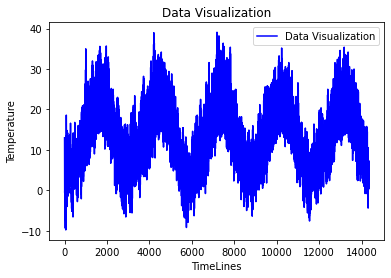

In [244]:
x_axis = range(len(temperature_df.values))
plt.figure()
plt.plot(x_axis, temperature_df.values, "b", label="Data Visualization")

plt.title("Data Visualization")
plt.xlabel("TimeLines")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [229]:
EPOCHS = 25
BATCH_SIZE= 16
UNITS = 40
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=UNITS, return_sequences=True, input_shape = (x_train.shape[1], 1))))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= UNITS, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= UNITS, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units= UNITS))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = n_future, activation='relu'))
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
regressor.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/25
717/717 [==============================] - 15s 8ms/step - loss: 115.7747 - acc: 0.2414
Epoch 2/25
717/717 [==============================] - 6s 8ms/step - loss: 24.7114 - acc: 0.3867
Epoch 3/25
717/717 [==============================] - 6s 8ms/step - loss: 16.8117 - acc: 0.5986
Epoch 4/25
717/717 [==============================] - 6s 8ms/step - loss: 14.3731 - acc: 0.6390
Epoch 5/25
717/717 [==============================] - 6s 8ms/step - loss: 13.1256 - acc: 0.6852
Epoch 6/25
717/717 [==============================] - 6s 8ms/step - loss: 12.1895 - acc: 0.6987
Epoch 7/25
717/717 [==============================] - 6s 8ms/step - loss: 11.8450 - acc: 0.7116
Epoch 8/25
717/717 [==============================] - 6s 8ms/step - loss: 11.5412 - acc: 0.7061
Epoch 9/25
717/717 [==============================] - 6s 8ms/step - loss: 11.2733 - acc: 0.7254
Epoch 10/25
717/717 [==============================] - 6s 8ms/step - loss: 11.1435 - acc: 0.7242
Epoch 11/25
717/717 [================

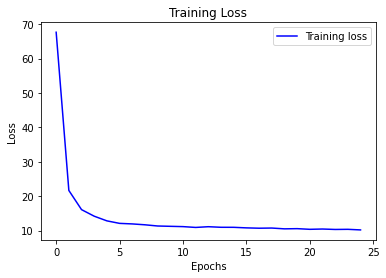

In [230]:
def visualize_loss(history, title):
    loss = history.history["loss"]
   
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(regressor.history, "Training Loss")

In [231]:
x_test = test_set[: n_past, 0]
y_test = test_set[n_past : n_past + n_future, 0]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (1, x_test.shape[0], 1))
predicted_temperature = regressor.predict(x_test)
print('Predicted temperature {}'.format(predicted_temperature))
print('Real temperature {}'.format(y_test))


Predicted temperature [[5.0998626 6.147852  6.0192556 4.8171134]]
Real temperature [3.6 4.  3.3 1.9]


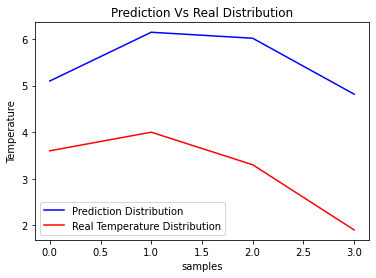

In [232]:
def visualize_temerature_trend(prediction,real,range_val, title):
    prediction_val = prediction
    real_val       = real
    range_val = range_val
    plt.figure()
    plt.plot(range(range_val), prediction_val, "b", label="Prediction Distribution")
    plt.plot(range(range_val), real_val, "r", label="Real Temperature Distribution")
    plt.title(title)
    plt.xlabel("samples")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()


visualize_temerature_trend(predicted_temperature[0],y_test,4, "Prediction Vs Real Distribution")

In [235]:
last_five_observations =np.array([7,8,8,9,10,9,7,5,2,4,5])
last_five_observations = np.reshape(last_five_observations, (1, last_five_observations.shape[0], 1))
predicted_temperature = regressor.predict(last_five_observations)


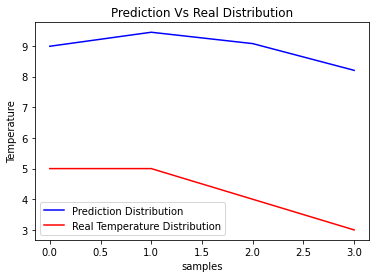

In [236]:
visualize_temerature_trend(predicted_temperature[0],[5,5,4,3],4, "Prediction Vs Real Distribution")